<a href="https://colab.research.google.com/drive/1MmS_b3u46WsAs_gDrFm5Vci2II-SA68t#scrollTo=tOe8w59LlsUp" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from zipfile import ZipFile

with ZipFile("drive/My Drive/AM/Project-OCR/noisydata_all.zip", 'r') as zip_:
    print('Extracting...') 
    zip_.extractall()
    print('Done!')

Extracting...
Done!


In [0]:
import os
import cv2
import numpy as np

import seaborn as sns
from matplotlib import pyplot

from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
orig_images = []
noisy_images = []
for img_name in os.listdir("noisy_data/"):
    if "orig" in img_name:
        orig_images.append(img_name)
    else:
        noisy_images.append(img_name)

orig_images = sorted(orig_images, key=lambda x: int(x.split("_")[0]))
noisy_images = sorted(noisy_images, key=lambda x: int(x.split("_")[0]))

assert len(orig_images) == len(noisy_images)

In [0]:
Xorig, Xnoisy = [], []

for o_img, n_img in zip(orig_images, noisy_images):
    img = cv2.imread("noisy_data/"+o_img, 0)
    img = np.expand_dims(img, 2)
    Xorig.append(img)

    img = cv2.imread("noisy_data/"+n_img, 0)
    img = np.expand_dims(img, 2)
    Xnoisy.append(img)

Xorig = np.array(Xorig)
Xnoisy = np.array(Xnoisy)

Xorig.shape, Xnoisy.shape

((4356, 80, 256, 1), (4356, 80, 256, 1))

In [0]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xnoisy, Xorig, train_size=0.85, random_state=42)

Xtrain = Xtrain.astype('float32') / 255.
Xtest = Xtest.astype('float32') / 255.
ytrain = ytrain.astype('float32') / 255.
ytest = ytest.astype('float32') / 255.

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3702, 80, 256, 1), (654, 80, 256, 1), (3702, 80, 256, 1), (654, 80, 256, 1))

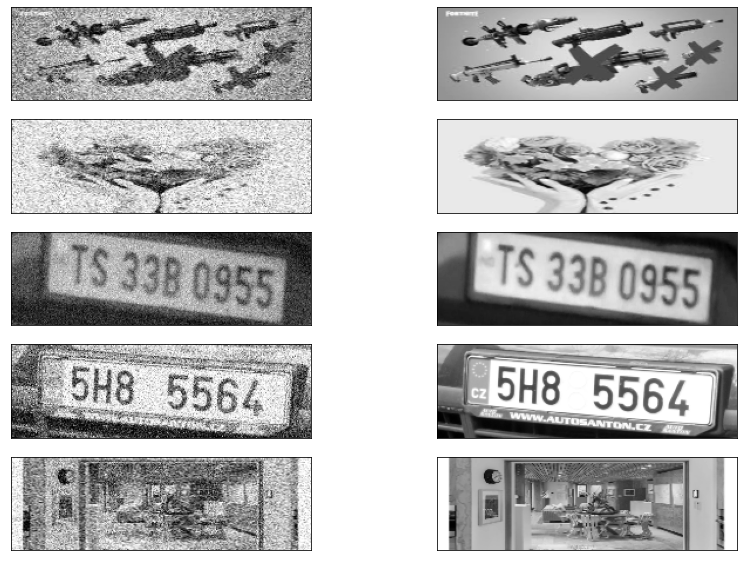

In [0]:
sns.reset_orig()

fig = pyplot.figure(1, (14, 10))

i = 1
for idx in np.random.randint(0,200,5):
    img = Xtrain[idx,:,:,0]
    ax = pyplot.subplot(5,2, i)
    ax.imshow(img, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1

    img = ytrain[idx,:,:,0]
    ax = pyplot.subplot(5,2, i)
    ax.imshow(img, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1

In [0]:
def encoder_block(X, filters: list, blockid: int, do: float = 0.):
    X = Conv2D(
        filters[0],
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name=f'encblock{blockid}_conv1',
    )(X)
    
    if do > 0.:
        X = Dropout(do, name=f'encblock{blockid}_do')(X)

    
    X = Conv2D(
        filters[1],
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name=f'encblock{blockid}_conv2',
    )(X)
        
    return X

In [0]:
def decoder_block(X1, X2, filters: list, blockid: int, do: float = 0.):
    X1 = Conv2DTranspose(
        filters[0],
        (2, 2),
        strides=(2, 2),
        padding='same',
        name=f'decblock{blockid}_convtrans',
    )(X1)

    X1 = concatenate([X1, X2])

    X1 = Conv2D(
        filters[0],
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name=f'decblock{blockid}_conv1',
    )(X1)

    if do > 0.:
        X1 = Dropout(do, name=f'decblock{blockid}_do',)(X1)

    X1 = Conv2D(
        filters[1],
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name=f'decblock{blockid}_conv2',
    )(X1)

    return X1

In [0]:
def denoiser_unet(img_shape, show_summary=False):
    model_in = Input(img_shape, name="input_layer")

    # encoding
    e1 = encoder_block(model_in, [16, 32], blockid=1, do=0.)
    X = MaxPooling2D((2, 2), name='pool1')(e1)

    e2 = encoder_block(X, [64, 128], blockid=2, do=0.)
    X = MaxPooling2D((2, 2), name='pool2')(e2)

    e3 = encoder_block(X, [256, 512], blockid=3, do=0.)
    X = MaxPooling2D((2, 2), name='pool3')(e3)

    # e4 = encoder_block(X, 128, blockid=4, do=0.)
    # X = MaxPooling2D((2, 2), name='pool4')(e4)

    # latent space
    ls = Conv2D(
        1024,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same'
    )(X)
    # ls = Dropout(0.3)(ls)
    ls = Conv2D(
        1024,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same'
    )(ls)

    # decoding
    # d1 = decoder_block(ls, e4, 128, blockid=1, do=0.)
    d2 = decoder_block(ls, e3, [512, 256], blockid=2, do=0.)
    d3 = decoder_block(d2, e2, [128, 64], blockid=3, do=0.)
    d4 = decoder_block(d3, e1, [32, 16], blockid=4, do=0.)

    model_out = Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = Model(inputs=[model_in], outputs=[model_out], name="U-Net")
    
    if show_summary:
        model.summary()

    return model

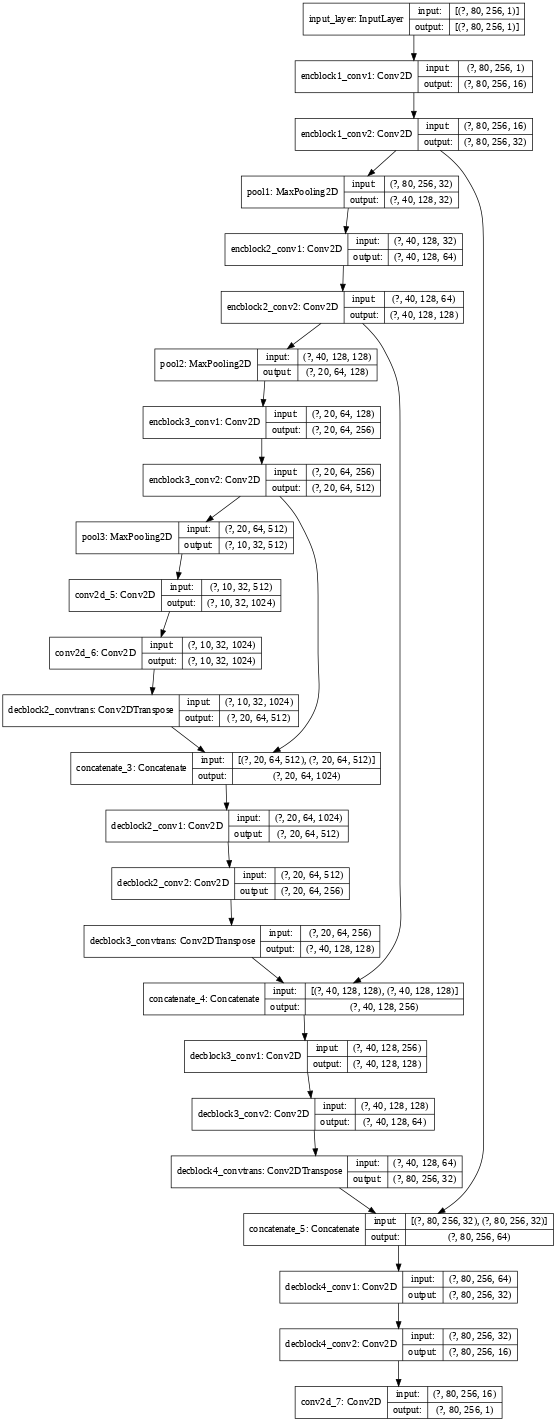

In [0]:
model = denoiser_unet(img_shape=(80, 256, 1))
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50,)

In [0]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    min_delta=0.001,
    factor=0.1,
    patience=4,
    min_lr=1e-8,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=9,
    verbose=1,
    restore_best_weights=True,
)

In [0]:
model.compile(
    optimizer=optimizers.Adam(0.001),
    loss='binary_crossentropy',
    metrics=['mae']
)

history = model.fit(
    x=Xtrain,
    y=ytrain,
    batch_size=16,
    epochs=25,
    validation_data=(Xtest, ytest),
    callbacks=[lr_scheduler]
)

Epoch 1/25
232/232 [==============================] - 29s 125ms/step - loss: 0.5612 - mae: 0.0786 - val_loss: 0.5432 - val_mae: 0.0510 - lr: 0.0010
Epoch 2/25
232/232 [==============================] - 29s 124ms/step - loss: 0.5399 - mae: 0.0494 - val_loss: 0.5414 - val_mae: 0.0491 - lr: 0.0010
Epoch 3/25
232/232 [==============================] - 29s 124ms/step - loss: 0.5386 - mae: 0.0464 - val_loss: 0.5411 - val_mae: 0.0473 - lr: 0.0010
Epoch 4/25
232/232 [==============================] - 29s 124ms/step - loss: 0.5378 - mae: 0.0445 - val_loss: 0.5388 - val_mae: 0.0416 - lr: 0.0010
Epoch 5/25
232/232 [==============================] - 29s 124ms/step - loss: 0.5371 - mae: 0.0427 - val_loss: 0.5384 - val_mae: 0.0404 - lr: 0.0010
Epoch 6/25
232/232 [==============================] - 29s 124ms/step - loss: 0.5366 - mae: 0.0415 - val_loss: 0.5377 - val_mae: 0.0395 - lr: 0.0010
Epoch 7/25
232/232 [==============================] - 29s 124ms/step - loss: 0.5365 - mae: 0.0411 - val_loss: 0.

In [0]:
# best 0.0363, 0.0355
model.save("unet.h5")

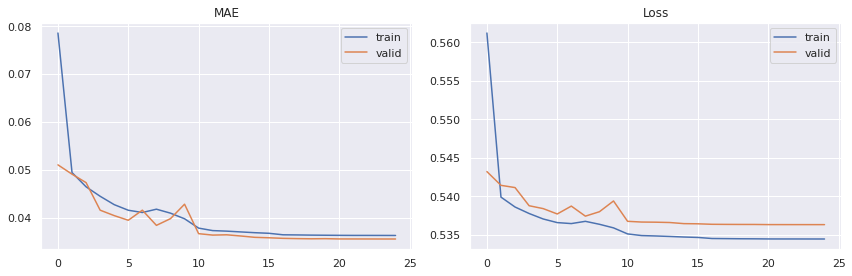

In [0]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['mae'], label='train')
sns.lineplot(history.epoch, history.history['val_mae'], label='valid')
pyplot.title('MAE')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.show()

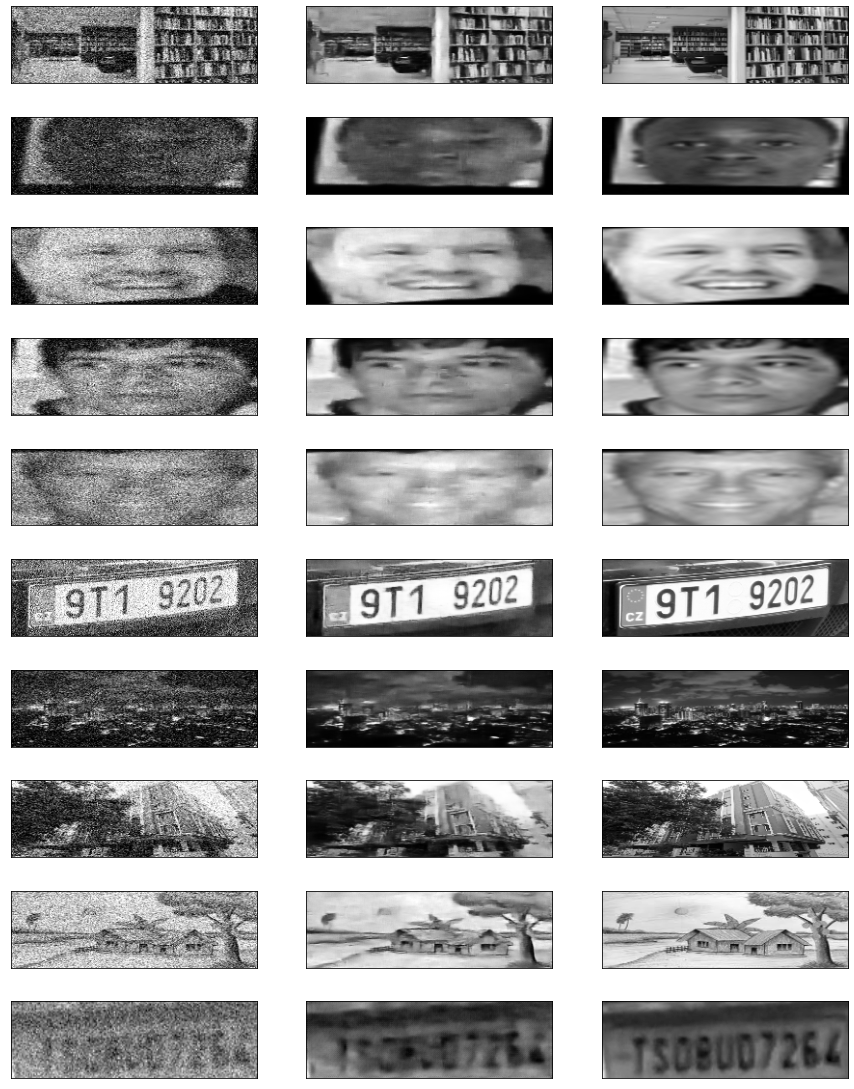

In [0]:
sns.reset_orig()

fig = pyplot.figure(1, (15, 20))

i = 1
for idx in np.random.randint(0,250,10):
    img = Xtrain[idx,:,:,0]
    ax = pyplot.subplot(10,3, i)
    ax.imshow(img, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1

    img = model.predict(np.expand_dims(Xtrain[idx,:,:,0], 0))
    ax = pyplot.subplot(10,3, i)
    ax.imshow(img[0,:,:,0], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1

    img = ytrain[idx,:,:,0]
    ax = pyplot.subplot(10,3, i)
    ax.imshow(img, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1

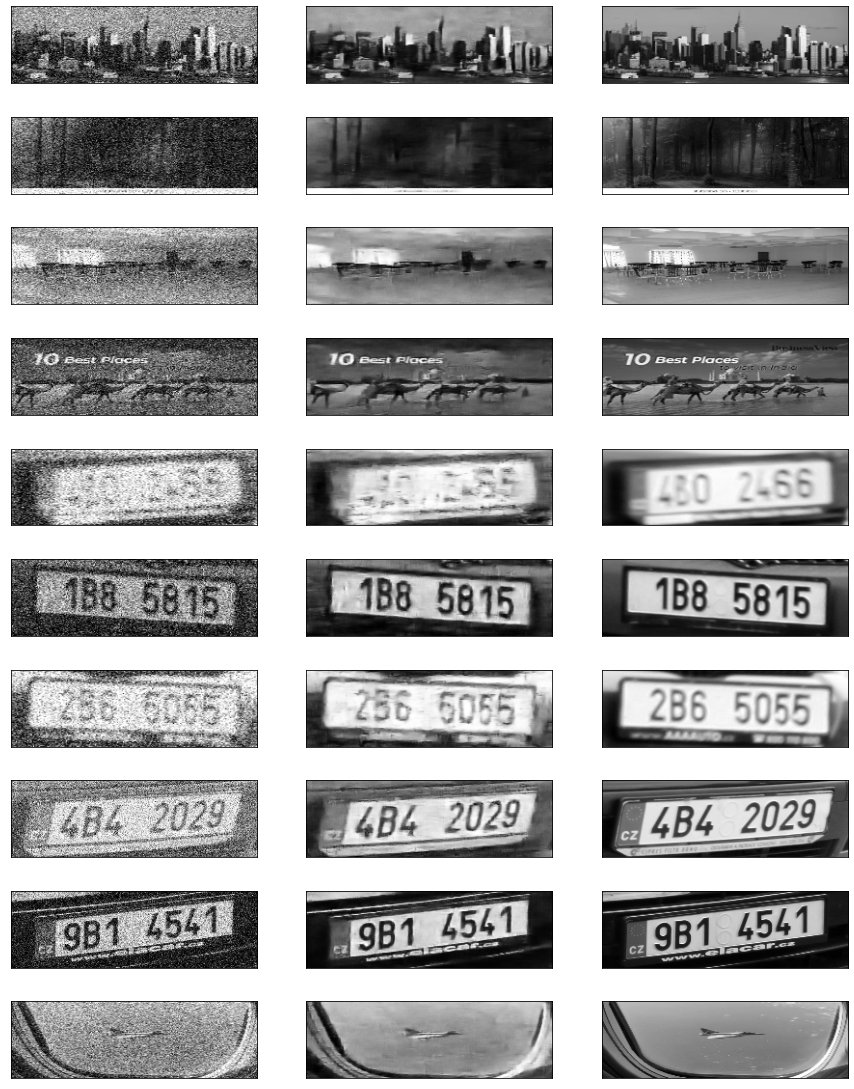

In [0]:
sns.reset_orig()

fig = pyplot.figure(1, (15, 20))

i = 1
for idx in np.random.randint(0,250,10):
    img = Xtest[idx,:,:,0]
    ax = pyplot.subplot(10,3, i)
    ax.imshow(img, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1

    img = model.predict(np.expand_dims(Xtest[idx,:,:,0], 0))
    ax = pyplot.subplot(10,3, i)
    ax.imshow(img[0,:,:,0], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1

    img = ytest[idx,:,:,0]
    ax = pyplot.subplot(10,3, i)
    ax.imshow(img, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1